In [10]:

import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

results_path = "results"

In [8]:

all_metrics = []

for folder in os.listdir(results_path):
    folder_path = os.path.join(results_path, folder)
    metrics_file = os.path.join(folder_path, "global_metrics.csv")

    if os.path.isdir(folder_path) and os.path.exists(metrics_file):
        df = pd.read_csv(metrics_file)
        df["experiment_name"] = folder
        all_metrics.append(df)

global_metrics_df = pd.concat(all_metrics, ignore_index=True)

global_metrics_df = global_metrics_df.sort_values(by=["model_type", "model_complexity"])



In [9]:
global_metrics_df.head(20)


,backend,model_type,model_complexity,epochs,batch_size,seed,gpus,definition_time,training_time,testing_time,gpu_0_memory_total,experiment_name
3,tf-keras,cnn,complex,100,64,42,0,1.739127,1177.212403,4.892934,24570.0,20250220-004357_tf-keras_cnn_complex
9,torch-keras,cnn,complex,100,64,42,0,0.401508,7094.888878,15.069313,24570.0,20250220-042456_torch-keras_cnn_complex
2,tf-keras,cnn,simple,100,64,42,0,1.202388,349.230876,3.728730,24570.0,20250220-003756_tf-keras_cnn_simple
8,torch-keras,cnn,simple,100,64,42,0,0.219997,622.021604,2.054504,24570.0,20250220-041425_torch-keras_cnn_simple
5,tf-keras,lstm,complex,100,64,42,0,2.394718,4235.194065,9.496973,24570.0,20250220-011300_tf-keras_lstm_complex
4,tf-keras,lstm,simple,100,64,42,0,1.228235,440.049749,2.998861,24570.0,20250220-010350_tf-keras_lstm_simple
1,tf-keras,mlp,complex,100,64,42,0,1.534087,2605.363980,8.247892,24570.0,20250219-235411_tf-keras_mlp_complex
7,torch-keras,mlp,complex,100,64,42,0,0.489099,6058.384552,3.368353,24570.0,20250220-023315_torch-keras_mlp_complex
0,tf-keras,mlp,simple,100,64,42,0,1.171916,259.975747,2.599893,24570.0,20250219-234939_tf-keras_mlp_simple
6,torch-keras,mlp,simple,100,64,42,0,0.216115,451.607105,1.464619,24570.0,20250220-022533_torch-keras_mlp_simple


/tmp/ipykernel_3216773/1449289200.py:63: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig_train.subplots_adjust(hspace=0.3, wspace=0.3)  # Más espacio entre filas y columnas


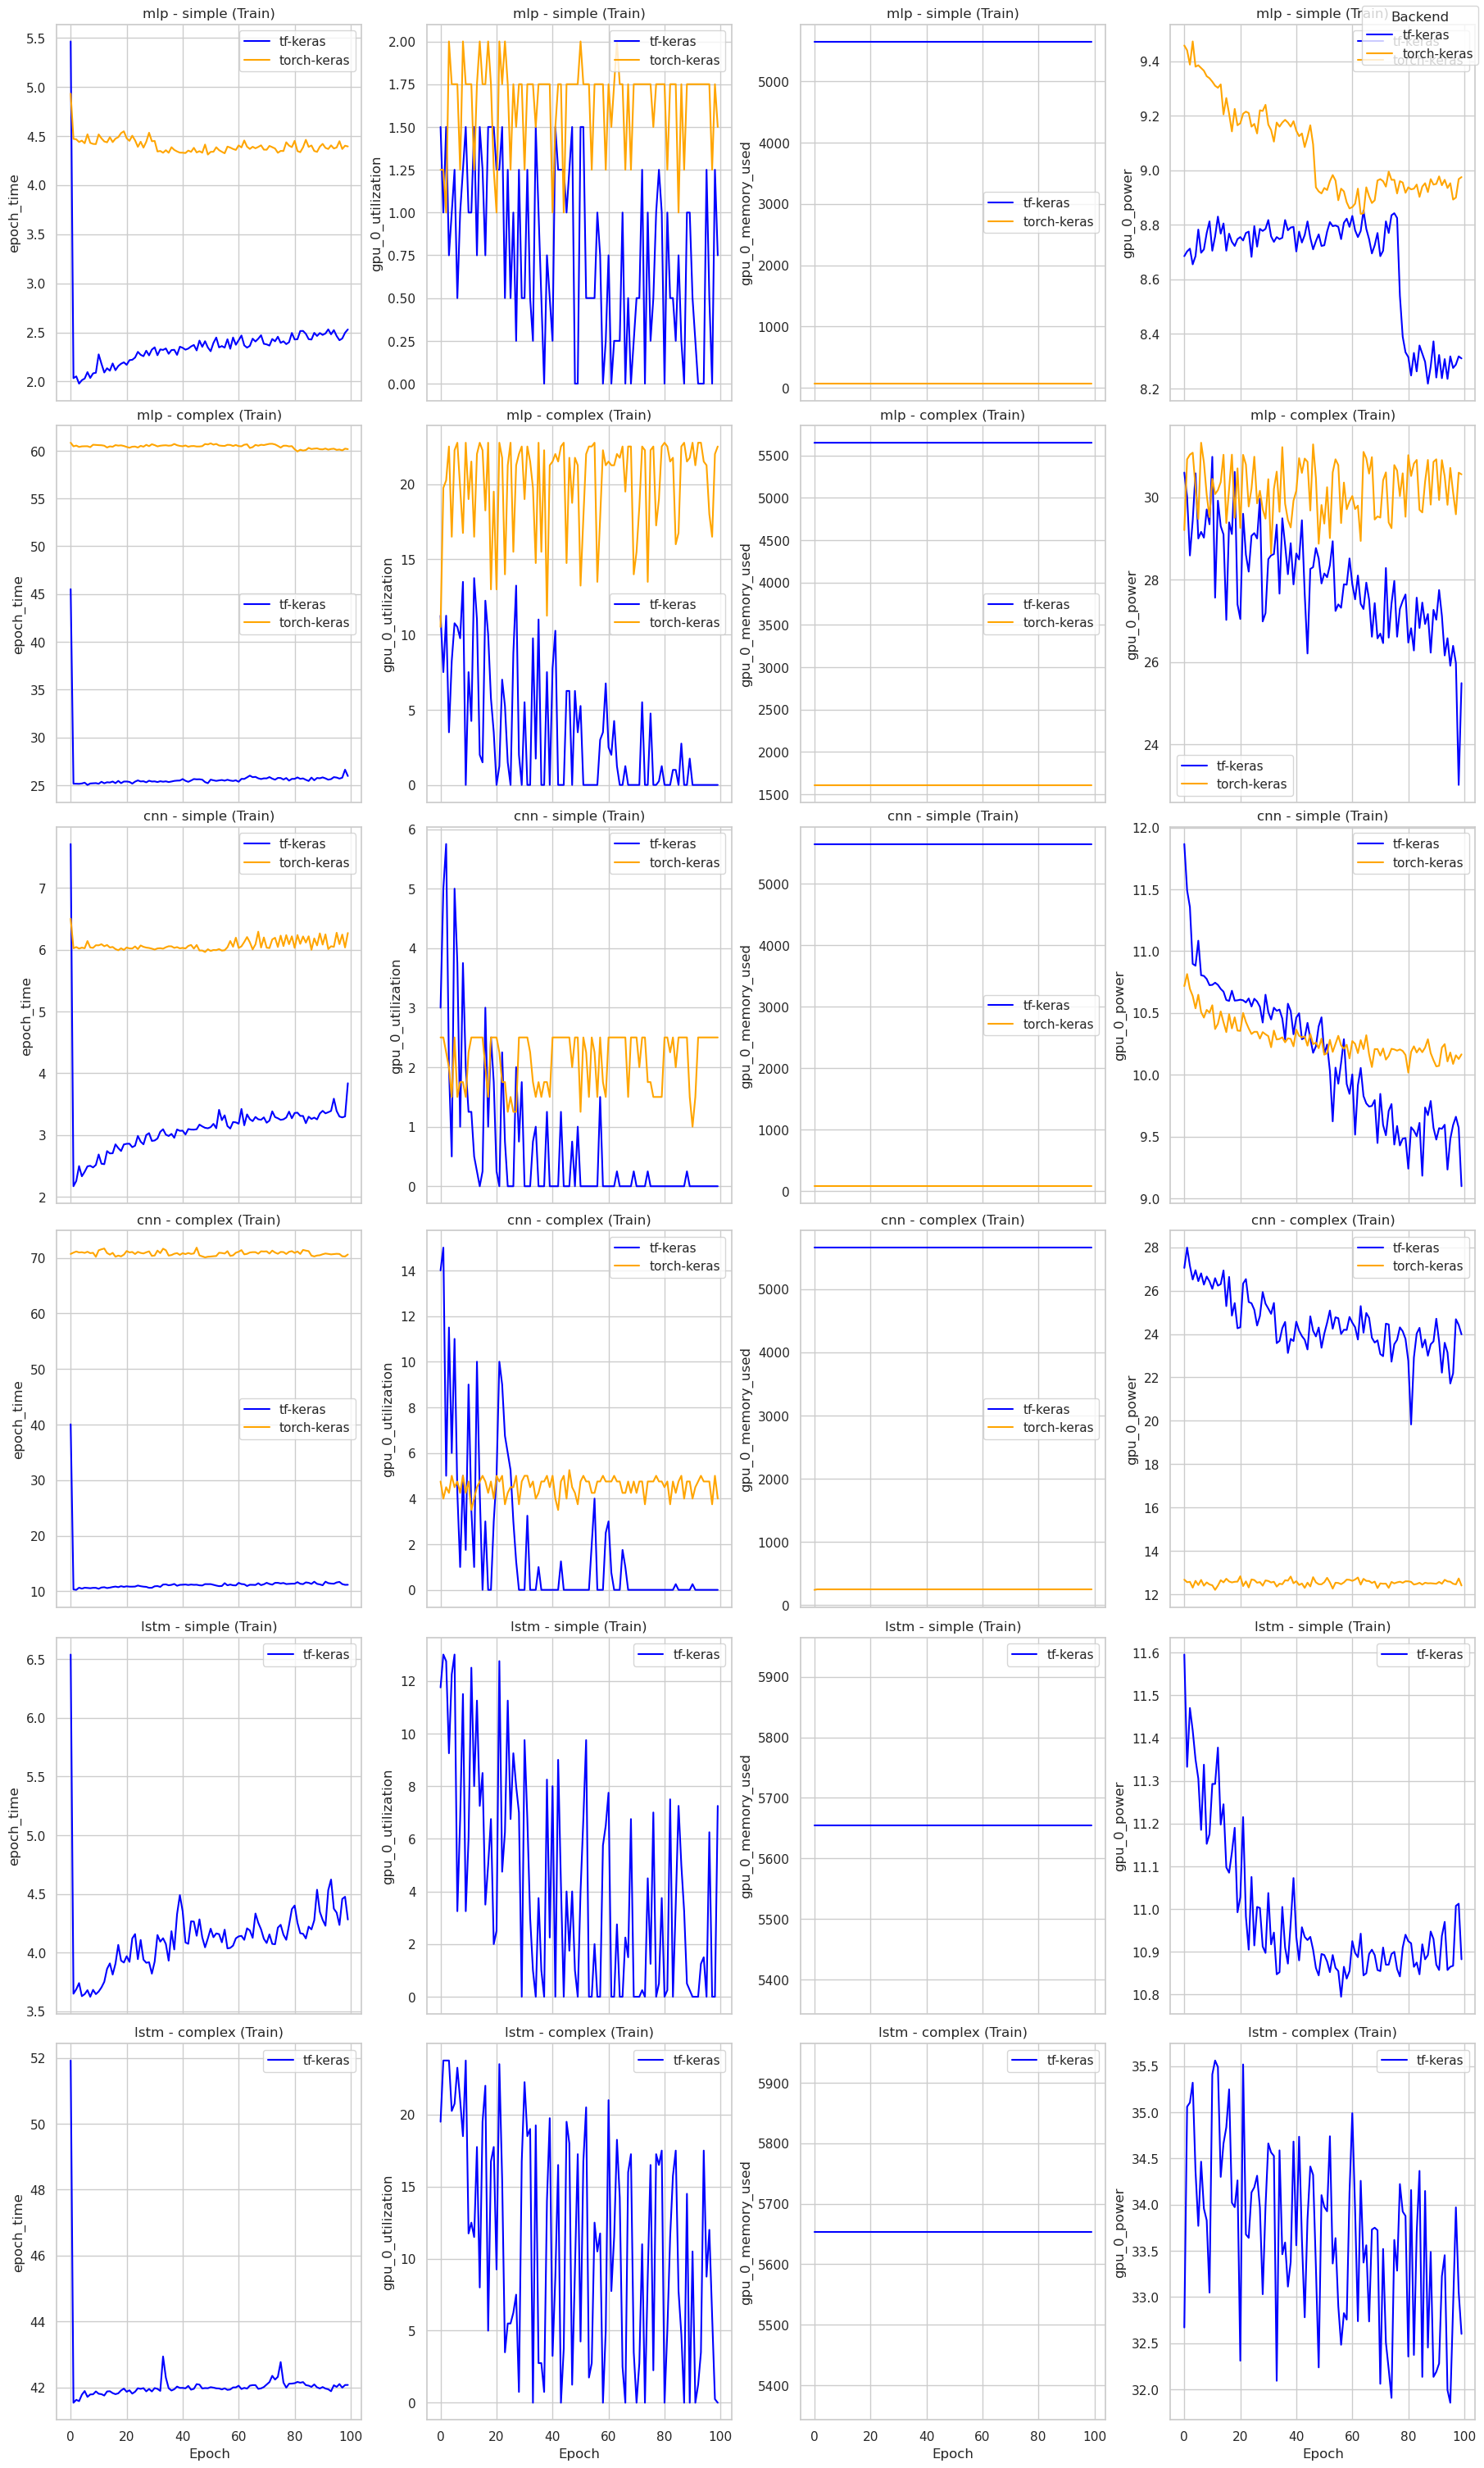

In [19]:
# Obtener lista de experimentos
experiments = [folder for folder in os.listdir(results_path) if os.path.isdir(os.path.join(results_path, folder))]

# Configurar estilo de seaborn
sns.set_theme(style="whitegrid")

# Definir métricas a graficar
metrics = ["epoch_time", "gpu_0_utilization", "gpu_0_memory_used", "gpu_0_power"]

# Diccionario para agrupar experimentos por model_type-model_complexity
experiments_dict = {}

for experiment in experiments:
    folder_path = os.path.join(results_path, experiment)
    global_metrics_file = os.path.join(folder_path, "global_metrics.csv")

    if os.path.exists(global_metrics_file):
        # Leer global_metrics para obtener backend, model_type y model_complexity
        global_metrics_df = pd.read_csv(global_metrics_file)
        model_type = global_metrics_df['model_type'][0]
        model_complexity = global_metrics_df['model_complexity'][0]
        backend = global_metrics_df['backend'][0]

        key = (model_type, model_complexity)
        if key not in experiments_dict:
            experiments_dict[key] = []
        experiments_dict[key].append((backend, folder_path))

# Crear subgráficos con más separación: cada fila es un model_type-model_complexity, 4 columnas por métrica
fig_train, axes_train = plt.subplots(len(experiments_dict), 4, figsize=(18, 5 * len(experiments_dict)), sharex=True, constrained_layout=True)

# Colores fijos por backend
colors = ["blue", "orange", "green", "red", "purple"]  # Puedes ampliar la lista si hay más backends
backend_colors = {}

for i, ((model_type, model_complexity), experiment_list) in enumerate(experiments_dict.items()):
    for backend, folder_path in experiment_list:
        train_file = os.path.join(folder_path, "train.csv")

        if os.path.exists(train_file):
            # Asignar color al backend si no está en el diccionario
            if backend not in backend_colors:
                backend_colors[backend] = colors[len(backend_colors) % len(colors)]

            # Cargar train y test
            train_df = pd.read_csv(train_file)

            # Dibujar gráficos de TRAIN
            for j, metric in enumerate(metrics):
                ax = axes_train[i, j] if len(experiments_dict) > 1 else axes_train[j]
                sns.lineplot(data=train_df, x="epoch", y=metric, ax=ax, color=backend_colors[backend], label=f"{backend}")

                ax.set_title(f"{model_type} - {model_complexity} (Train)")
                ax.set_xlabel("Epoch")
                ax.set_ylabel(metric)


# Agregar leyendas globales
handles, labels = axes_train[0, 0].get_legend_handles_labels()
fig_train.legend(handles, labels, title="Backend", loc="upper right")

# Mejorar distribución de los gráficos
fig_train.subplots_adjust(hspace=0.3, wspace=0.3)  # Más espacio entre filas y columnas

# Mostrar gráficos
plt.show()

In [26]:
all_test_results = []

for folder in os.listdir(results_path):
    folder_path = os.path.join(results_path, folder)
    test_file = os.path.join(folder_path, "test.csv")
    global_metrics_file = os.path.join(folder_path, "global_metrics.csv")

    if os.path.isdir(folder_path) and os.path.exists(test_file) and os.path.exists(global_metrics_file):
        # Cargar test.csv
        df = pd.read_csv(test_file)

        # Cargar global_metrics.csv para obtener model_type y model_complexity
        global_metrics_df = pd.read_csv(global_metrics_file)
        model_type = global_metrics_df["model_type"][0]
        model_complexity = global_metrics_df["model_complexity"][0]

        # Agregar columnas al DataFrame de test
        df["experiment_name"] = folder
        df["model_type"] = model_type
        df["model_complexity"] = model_complexity

        all_test_results.append(df)

# Concatenar todos los DataFrames en uno solo
test_results_df = pd.concat(all_test_results, ignore_index=True)

# Ordenar por model_type y model_complexity
test_results_df = test_results_df.sort_values(by=["model_type", "model_complexity"])


In [27]:
test_results_df.head(20)

,epoch,accuracy,loss,epoch_time,gpu_0_utilization,gpu_0_memory_used,gpu_0_power,experiment_name,model_type,model_complexity,mae
3,0,0.3257,5.689210,4.209446,0.00,5655.0,11.3825,20250220-004357_tf-keras_cnn_complex,cnn,complex,NaN
9,0,0.3523,4.747008,14.964238,1.50,250.5,9.7500,20250220-042456_torch-keras_cnn_complex,cnn,complex,NaN
2,0,0.5310,1.506532,3.029321,0.00,5650.5,8.2800,20250220-003756_tf-keras_cnn_simple,cnn,simple,NaN
8,0,0.5436,1.484185,1.914754,0.75,82.0,8.8125,20250220-041425_torch-keras_cnn_simple,cnn,simple,NaN
5,0,NaN,0.046517,9.045852,10.50,5654.0,28.8250,20250220-011300_tf-keras_lstm_complex,lstm,complex,0.154455
4,0,NaN,0.023939,2.399799,0.00,5654.0,9.9975,20250220-010350_tf-keras_lstm_simple,lstm,simple,0.114065
1,0,0.8823,0.592583,7.647245,0.00,5650.5,9.4350,20250219-235411_tf-keras_mlp_complex,mlp,complex,NaN
7,0,0.8960,0.370691,3.257504,7.50,1609.5,16.9750,20250220-023315_torch-keras_mlp_complex,mlp,complex,NaN
0,0,0.8995,0.353044,2.197012,0.00,5650.0,8.1850,20250219-234939_tf-keras_mlp_simple,mlp,simple,NaN
6,0,0.9031,0.336445,1.348632,0.75,69.5,8.6950,20250220-022533_torch-keras_mlp_simple,mlp,simple,NaN
